# Wind Power Forecast Model

In [60]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, WindPowerForecastModelParameter, _inv_logit, _logit

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Forecast Simulations

In [68]:
params = WindPowerForecastModelParameter(n_call_strikes=40, min_strike=-7.0, max_strike=7.0)
model = WindPowerForecastModel('Onshore', speed_of_mean_reversion=0.5, volatility=1.5, params=params)

In [62]:
_inv_logit(1.3)

0.7858349830425586

In [69]:
timegrid = np.linspace(0.0,1.0, 365)
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(10_000, timegrid.shape[0]))
results = model.simulate(timegrid, rnd, expiries=[1.0], initial_forecasts=[0.8], startvalue=0.0)

In [70]:
onshore_wind = results.get('Onshore_FWD0')

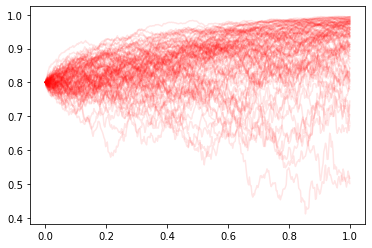

In [71]:
for i in range(100):
    plt.plot(timegrid, onshore_wind[:,i],'-r', alpha=0.1)

In [73]:
print(results._ou_additive_forward_corrections)
onshore_wind[-1,:].mean()

[2.88553198]


0.9119950229158156

(array([  2.,   1.,   1.,   2.,   4.,   1.,   6.,   4.,   3.,  10.,  10.,
         11.,  16.,  14.,  21.,  24.,  25.,  19.,  42.,  37.,  47.,  52.,
         51.,  66.,  69.,  87., 101., 100., 131., 128., 150., 160., 183.,
        200., 208., 199., 248., 243., 278., 266., 276., 307., 316., 294.,
        296., 332., 314., 275., 296., 276., 287., 276., 286., 254., 252.,
        238., 247., 211., 202., 169., 160., 182., 125., 124.,  95.,  92.,
         80.,  69.,  83.,  58.,  50.,  48.,  39.,  21.,  34.,  26.,  13.,
         18.,   7.,   8.,   6.,   8.,   5.,   6.,   6.,   3.,   3.,   3.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([-5.05908299e+00, -4.94919086e+00, -4.83929873e+00, -4.72940660e+00,
        -4.61951447e+00, -4.50962234e+00, -4.39973021e+00, -4.28983808e+00,
        -4.17994595e+00, -4.07005382e+00, -3.96016169e+00, -3.85026956e+00,
        -3.74037744e+00, -3.63048531e+00, -3.52059318e+00, -3.41070105e+00,
        -3.300

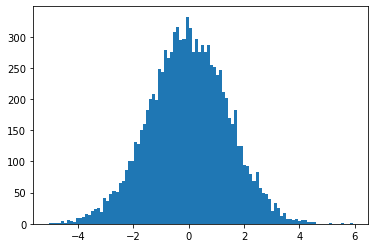

In [47]:
plt.hist(results._paths[-1,:], bins=100)

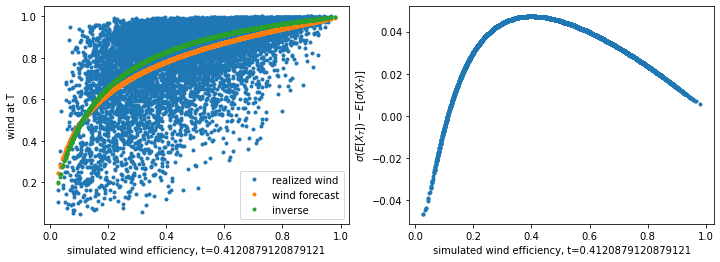

In [45]:
timepoint = 150
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x = _inv_logit(results._paths[timepoint,:])
plt.plot(x,_inv_logit(results._paths[-1,:]+results._ou_additive_forward_corrections[0]),'.', label='realized wind')
inv_logit_from_expectation =  _inv_logit(model.ou.compute_expected_value(results._paths[timepoint,:]+ results._ou_additive_forward_corrections[0], 
                                                       T=timegrid[-1]-timegrid[timepoint])) 
plt.plot(x, onshore_wind[timepoint,:],'.', label='wind forecast')
plt.plot(x,inv_logit_from_expectation,'.', label='inverse')
plt.xlabel('simulated wind efficiency, t='+str(timegrid[timepoint]))
plt.ylabel('wind at T')
plt.legend();
plt.subplot(1,2,2)
plt.plot(x, inv_logit_from_expectation-onshore_wind[timepoint,:],'.')
plt.xlabel('simulated wind efficiency, t='+str(timegrid[timepoint]))
plt.ylabel('$\sigma(E[X_T])-E[\sigma(X_T)]$');

In [30]:
results._ou_additive_forward_corrections

array([2.08225941])

In [ ]:
from rivapy.models.residual_demand_fwd_model import _logit, _inv_logit
    
left = -7.0
right = 10.0
x = np.linspace(start=left,stop=right,num=1000)
y = _inv_logit(x)
plt.plot(x,y)

strikes = np.linspace(start=-5, stop=5, num=10)
#np.interp(x, strikes, _inv_logit(strikes))
def compute_call_weights(strikes,f): #we assume that f(strikes[0])=0 but nevertheless f.shape[0] == strikes.shape[0], i.e. zero is included
    weights = np.zeros((strikes.shape[0]+1))
    h = strikes[1]-strikes[0]
    butterfly_weights = [1, -2,  1]/h
    for s in range(1,strikes.shape[0]):
        weights[s-1] += f[s]*butterfly_weights[0]
        weights[s] += f[s]*butterfly_weights[1]
        weights[s+1] += f[s]*butterfly_weights[2]
    weights[-2] -= 0.5* butterfly_weights[1]*f[s]
    return weights[:-1]

def eval_call_functions(strikes, weights, x):
    #weights = compute_call_weights(strikes, _inv_logit(strikes))
    approx = np.copy(weights[0]*np.maximum(x-strikes[0],0.0))
    for i in range(1,weights.shape[0]):
        approx += weights[i]*np.maximum(x-strikes[i],0.0)
    return approx
weights = compute_call_weights(strikes, _inv_logit(strikes))
plt.plot(x,eval_call_functions(strikes, weights, x), '-')
plt.figure()
plt.plot(eval_call_functions(strikes, weights, x)-_inv_logit(x))